In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from seaborn import heatmap
from tqdm import tqdm
from scipy.stats import norm


## Hyperparameter Selection

Main hyperparameter to select is picking theta bounds that cover possible values in mark to market update: a portfolio's contract allocation when contracts are cheap increases when contracts increase in price during mark to market.

In [ ]:
B_TICK_MIN=-.80
B_TICK_MAX=.80
C_MIN=.01
C_MAX=.99

def get_theta_bounds(c_min, c_max, b_tick_min, b_tick_max):
    """
    Get the bounds of theta given the price and allocation bounds
    
    Returns:
        x0: float
            Lower bound of theta
        x1: float
            Upper bound of theta
    """
    x0 = None
    x1 = None
    
    if b_tick_min < 0:
        R_min = (1 - c_min) / (1 - c_max)
    else:
        R_min = c_min / c_max
    
    if b_tick_max < 0:
        R_max = (1 - c_max) / (1 - c_min)
    else:
        R_max = c_max / c_min
    
    x0 = b_tick_min * R_min / (1 - abs(b_tick_min) + abs(b_tick_min) * R_min)
    x1 = b_tick_max * R_max / (1 - abs(b_tick_max) + abs(b_tick_max) * R_max)
    return x0, x1

get_theta_bounds(C_MIN, C_MAX, B_TICK_MIN, B_TICK_MAX)    

(-0.9974811083123425, 0.9974811083123425)

In [ ]:
# Pick theta bounds that covers min and max theta from mark to market update
THETA_MIN=-.999
THETA_MAX=.999

## Price Transition Matrix

We demonstrate DP on 3 market price transition assumptions:
* Uniform (Market Uninformed)
* Random Walk
* Random Walk w/ mean reversion to p_subj (to simulate trader's alpha being diffused over time)

In [ ]:
def make_transition_matrix(fair_value: float = 0.5, 
                          volatility: float = 0.2, 
                          mean_reversion: float = 0.2, 
                          dist: str = None, 
                          n_prices: int = 99,
                          eps: float = 1e-6):
    """
    Random walk in log-odds space with mean reversion.
    
    Avoid p = 0 or 1 exactly by using eps.
    
    dist == Uniform returns uniform transition matrix
    """
    if dist == "uniform":
        M = np.ones((n_prices, n_prices)) / n_prices
        return M
    elif dist != None:
        raise NotImplementedError(f"Distribution {dist} not implemented")
    
    # Avoid 0 and 1 exactly
    p_grid = np.linspace(eps, 1 - eps, n_prices)
    
    # Convert fair_value to log-odds
    L_fair = np.log(fair_value / (1 - fair_value))
    
    # Build transition matrix
    M = np.zeros((n_prices, n_prices))
    L_grid = np.log(p_grid / (1 - p_grid))
    
    for i, p_t in enumerate(p_grid):
        # Current log-odds
        L_t = np.log(p_t / (1 - p_t))
        
        # Mean in log-odds space after mean reversion
        L_next_mean = L_t + mean_reversion * (L_fair - L_t)
        
        # Density in log-odds space evaluated on grid
        pdf_logit = norm.pdf(L_grid, loc=L_next_mean, scale=volatility)
        
        # Convert density to probability space using Jacobian
        # f_p(p) = f_L(logit(p)) * |dL/dp| = f_L * 1/(p*(1-p))
        jacobian = 1 / (p_grid * (1 - p_grid))
        pdf_prob = pdf_logit * jacobian
        
        # Normalize (sum over possible next prices = 1)
        M[i, :] = pdf_prob / pdf_prob.sum()
    
    return M

Text(50.722222222222214, 0.5, 'Current Price')

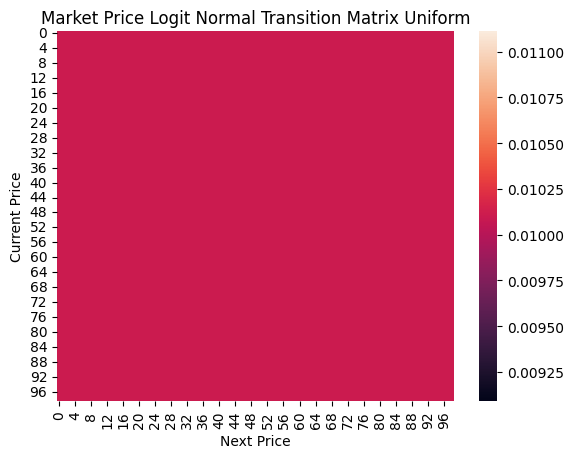

In [548]:
plt.title("Market Price Logit Normal Transition Matrix Uniform") 
heatmap(make_transition_matrix(dist="uniform",n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

Text(50.722222222222214, 0.5, 'Current Price')

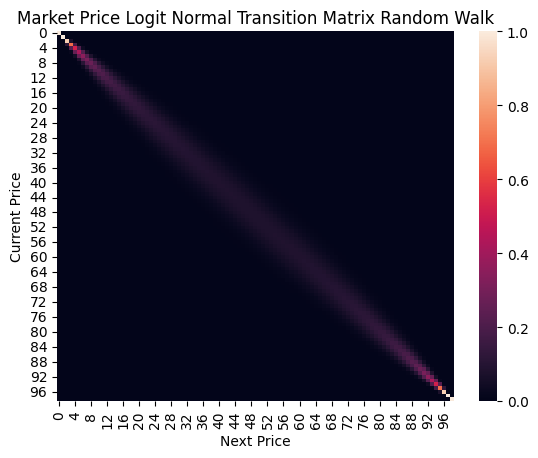

In [549]:
plt.title("Market Price Logit Normal Transition Matrix Random Walk")    
heatmap(make_transition_matrix(.7,.2,mean_reversion=0,n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

Text(50.722222222222214, 0.5, 'Current Price')

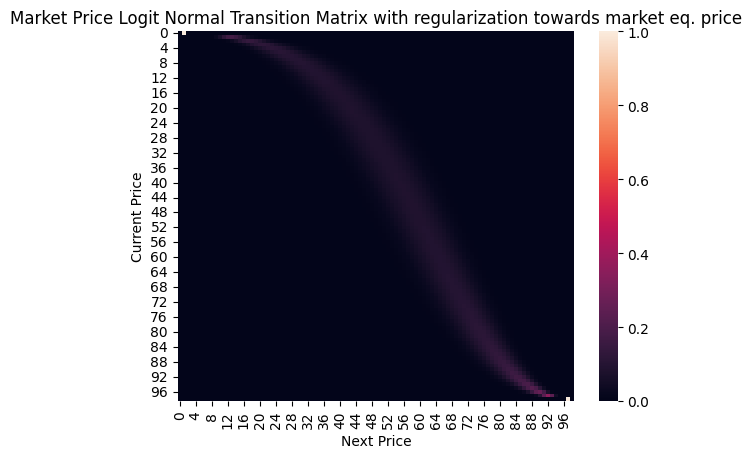

In [550]:
plt.title("Market Price Logit Normal Transition Matrix with regularization towards market eq. price")   
heatmap(make_transition_matrix(fair_value=.7,volatility=.2,mean_reversion=.5,n_prices=99))
plt.xlabel("Next Price")
plt.ylabel("Current Price")

## DP Code

In [ ]:
def run_dp(
    model_trans: np.ndarray,
    p_subj: float,
    gamma_yes_b: float = 0.05,
    gamma_yes_s: float = 0.10,
    gamma_no_b: float = 0.05,
    gamma_no_s: float = 0.10,
    T: int = 20,
    n_theta: int = 3000,
    n_b_tick: int = 100,
    n_prices: int = 99,
) -> Tuple[np.ndarray, np.ndarray]:
    
    # ========== STATE/ACTION GRIDS ==========
    theta_grid = np.linspace(THETA_MIN, THETA_MAX, n_theta)
    price_grid = np.linspace(C_MIN, C_MAX, n_prices)
    b_tick_grid = np.linspace(B_TICK_MIN, B_TICK_MAX, n_b_tick)
    
    # ========== PRECOMPUTE MARK TO MARKET UPDATE ==========
    R_yes_matrix = price_grid[None, :] / price_grid[:, None]
    R_no_matrix = (1 - price_grid[None, :]) / (1 - price_grid[:, None])
    
    theta_next_idx = np.zeros((n_b_tick, n_prices, n_prices), dtype=np.int16)
    
    for i_b_tick, b_tick in enumerate(b_tick_grid):
        if b_tick >= 0:
            R_matrix = R_yes_matrix
            numerator = R_matrix * b_tick
            denominator = 1 - b_tick + numerator
        else:
            R_matrix = R_no_matrix
            numerator = R_matrix * b_tick
            denominator = 1 + b_tick - numerator
        
        theta_next_vals = numerator / denominator
        
        idxs = ((theta_next_vals + THETA_MAX) / (2 * THETA_MAX) * (n_theta - 1)).astype(int)
        idxs = np.clip(idxs, 0, n_theta - 1)
        theta_next_idx[i_b_tick] = idxs
    
    # ========== PRECOMPUTE WEALTH UPDATE ==========
    theta_abs = np.abs(theta_grid)
    b_tick_abs = np.abs(b_tick_grid)
    
    # Avoid division by zero
    epsilon = 1e-12
    Theta = theta_abs / np.clip(1 - theta_abs, epsilon, np.inf)
    Beta = b_tick_abs / np.clip(1 - b_tick_abs, epsilon, np.inf)
    
    immediate = np.zeros((n_theta, n_b_tick))
    
    for i in range(n_theta):
        for j in range(n_b_tick):
            theta = theta_grid[i]
            b_tick = b_tick_grid[j]
            
            if abs(b_tick - theta) < epsilon:
                continue
                
            if theta >= 0:
                if b_tick >= 0:
                    if b_tick >= theta:
                        spread_theta = 1 + gamma_yes_b
                        spread_beta = 1 + gamma_yes_b
                    else:
                        spread_theta = 1 - gamma_yes_s
                        spread_beta = 1 - gamma_yes_s
                else:
                    spread_theta = 1 - gamma_yes_s
                    spread_beta = 1 + gamma_no_b
            else:
                if b_tick <= 0:
                    if abs(b_tick) >= abs(theta):
                        spread_theta = 1 + gamma_no_b
                        spread_beta = 1 + gamma_no_b
                    else:
                        spread_theta = 1 - gamma_no_s
                        spread_beta = 1 - gamma_no_s
                else:
                    spread_theta = 1 - gamma_no_s
                    spread_beta = 1 + gamma_yes_b
            
            num = np.clip(1 + Theta[i] * spread_theta, epsilon, np.inf)
            den = np.clip(1 + Beta[j] * spread_beta, epsilon, np.inf)
            immediate[i, j] = np.log(num) - np.log(den)
    
    # ========== DP TABLES ==========
    V = np.zeros((T + 1, n_theta, n_prices))
    policy = np.zeros((T, n_theta, n_prices))
    
    # ========== TERMINAL CONDITION ==========
    theta_T, C = np.meshgrid(theta_grid, price_grid, indexing='ij')
    theta_T_abs = np.abs(theta_T)
    mask = theta_T >= 0
    
    # Avoid numerical issues
    theta_T_abs_clipped = np.clip(theta_T_abs, 0, 1 - epsilon)
    denom_yes = np.clip(C * (1 - theta_T_abs_clipped), epsilon, np.inf)
    denom_no = np.clip((1 - C) * (1 - theta_T_abs_clipped), epsilon, np.inf)
    
    V_terminal = np.zeros_like(theta_T)
    V_terminal[mask] = p_subj * np.log(1 + theta_T_abs_clipped[mask] / denom_yes[mask])
    V_terminal[~mask] = (1 - p_subj) * np.log(1 + theta_T_abs_clipped[~mask] / denom_no[~mask])
    V[T] = V_terminal
    
    expected_future = np.zeros((n_b_tick, n_prices))
    # ========== BACKWARD INDUCTION ==========
    for t in tqdm(reversed(range(T)), total=T, desc="DP backward induction"):
            V_next = V[t + 1]
            
            for i_b_tick in range(n_b_tick):
                for i_c in range(n_prices):
                    trans_probs = model_trans[i_c, :]
                    theta_idx = theta_next_idx[i_b_tick, i_c, :]
                    v_vals = V_next[theta_idx, np.arange(n_prices)]
                    expected_future[i_b_tick, i_c] = np.dot(trans_probs, v_vals)
            
            for i_c in range(n_prices):
                total_vals = immediate + expected_future[:, i_c][None, :]
                best_b_idx = np.argmax(total_vals, axis=1)
                V[t, :, i_c] = total_vals[np.arange(n_theta), best_b_idx]
                policy[t, :, i_c] = b_tick_grid[best_b_idx]
    
    return V, policy

## #1 DP on Uniform Price Transitions

DP backward induction: 100%|██████████| 10/10 [00:00<00:00, 15.26it/s]


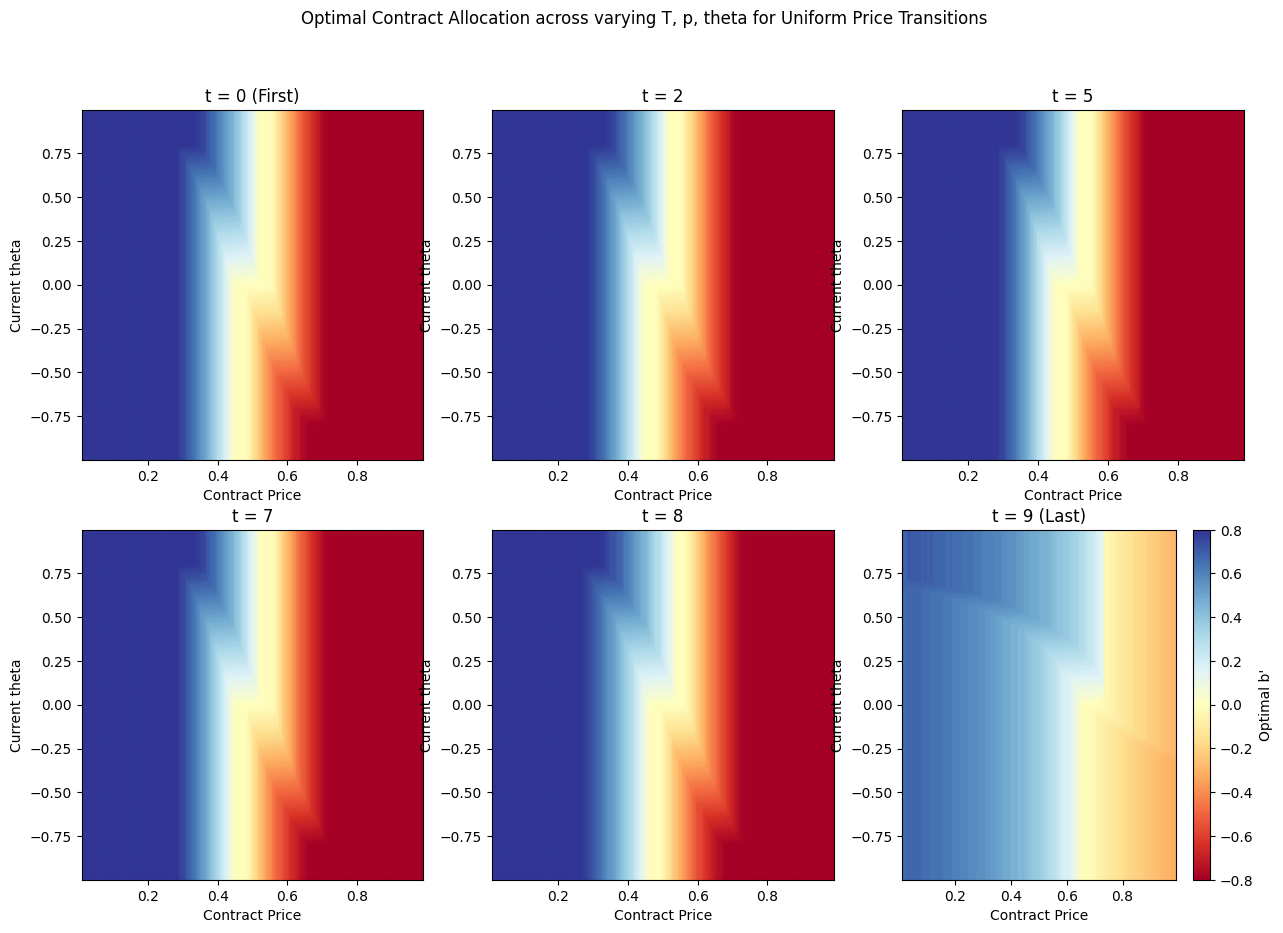

In [579]:
# Sample Policy 1: Uniform Price Transitions

T = 10
n_prices = 99
psub = .7
V, policy = run_dp(make_transition_matrix(dist="uniform",n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             n_theta = 3000,
                             n_b_tick = 100,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[C_MIN, C_MAX, THETA_MIN, THETA_MAX],  # Price: 0.01-0.99, Theta: -0.99-0.99
                   vmin=B_TICK_MIN, vmax=B_TICK_MAX,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b\'')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Uniform Price Transitions")
plt.show()


Policy is conservative, allocating very little except when contract price is at a minimum. Note that last time step's policy will always be the same since it is just greedy Kelly

This makes sense because the model expects extreme volatility now to continue onwards, so it's likely a contract price as cheap / cheaper will come about

## #2 DP on Random Walk Price Transitions

DP backward induction: 100%|██████████| 10/10 [00:00<00:00, 16.01it/s]


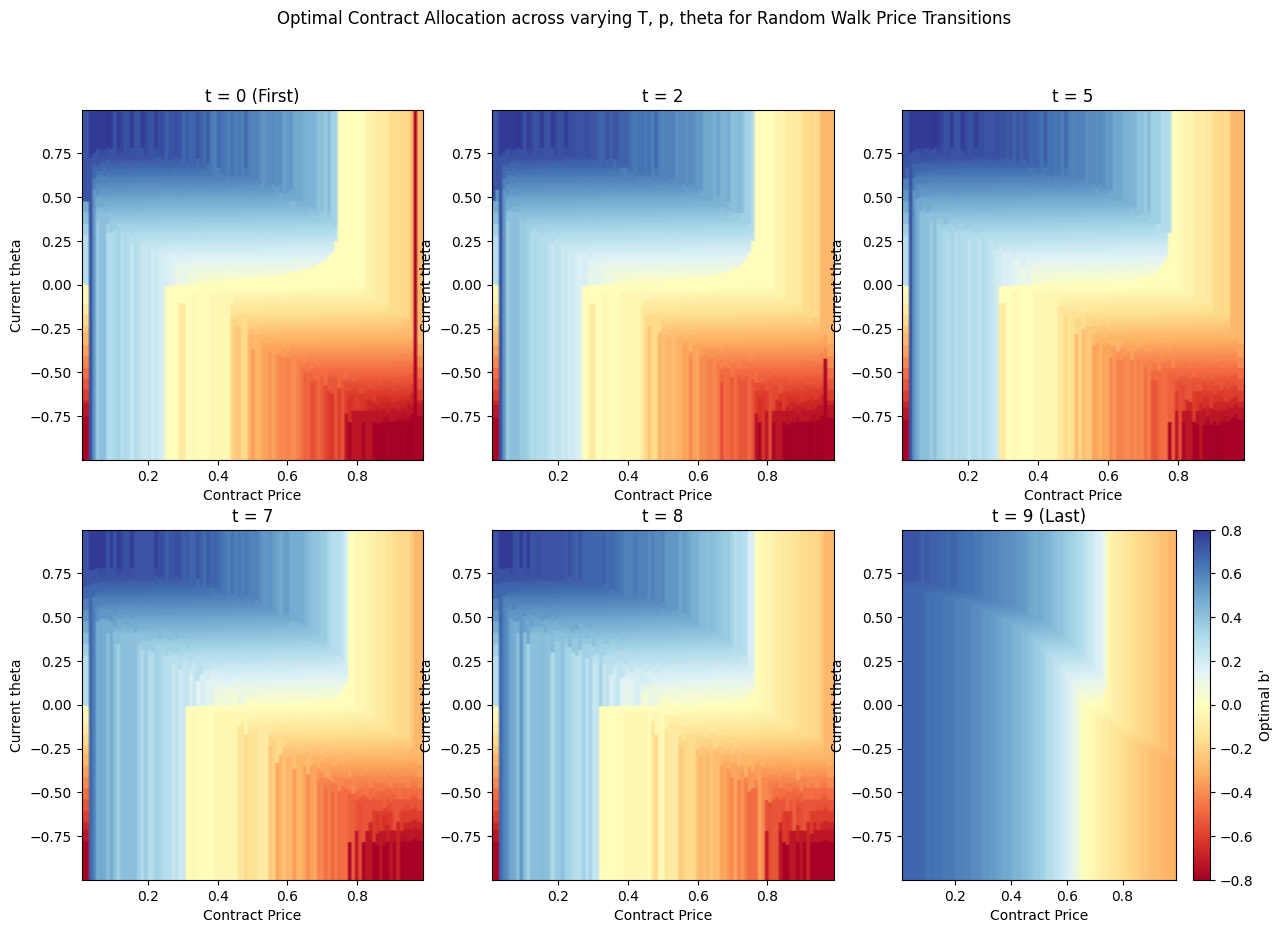

In [597]:
# Sample Policy 2: Random Walk Price Transitions

T = 10
n_prices = 99
psub = .7
V, policy = run_dp(make_transition_matrix(fair_value=psub,volatility=.2,mean_reversion=0,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             n_theta = 3000,
                             n_b_tick = 100,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[C_MIN, C_MAX, THETA_MIN, THETA_MAX],  # Price: 0.01-0.99, Theta: -0.99-0.99
                   vmin=B_TICK_MIN, vmax=B_TICK_MAX,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b\'')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions")
plt.show()


Policy is to allocate when price is cheap, but also save dry powder for cheaper prices (similar to #1). Notice the large no-trade region due to spread in the random walk regime.

## #3 DP on Random Walk Price Transitions with Regularization w/ mean reversion

DP backward induction: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


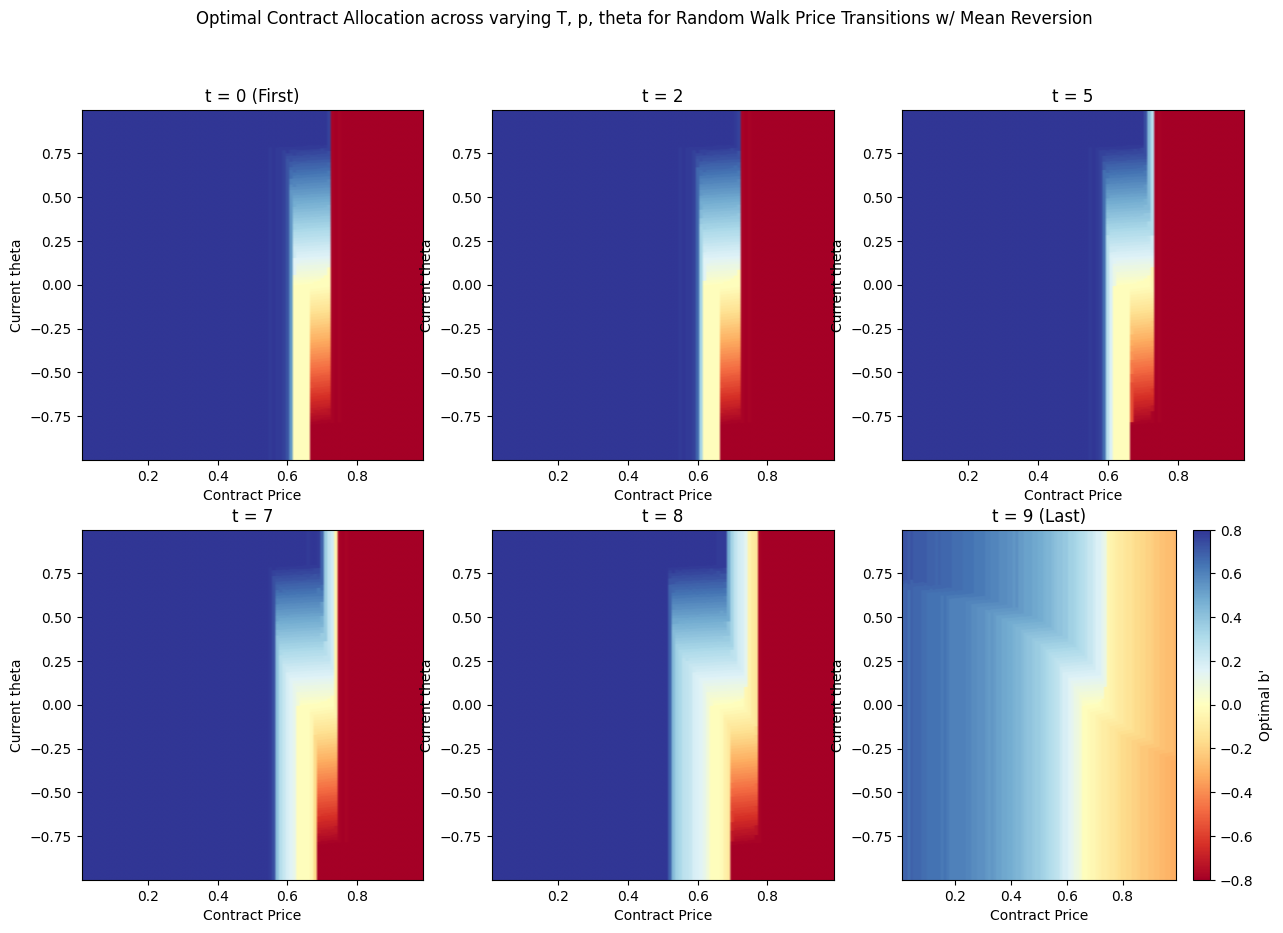

In [599]:
# Sample Policy 3: Random Walk Price Transitions w/ Mean Reversion

T = 10
n_prices = 99
psub = .7

V, policy = run_dp(make_transition_matrix(fair_value=psub,volatility=.2,mean_reversion=0.5,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             n_theta = 3000,
                             n_b_tick = 100,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[C_MIN, C_MAX, THETA_MIN, THETA_MAX],  # Price: 0.01-0.99, Theta: -0.99-0.99
                   vmin=B_TICK_MIN, vmax=B_TICK_MAX,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b\'')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions w/ Mean Reversion")
plt.show()


Similar policy to #2, but model now allocates much more earlier on, idea being cheap contracts are more rare since they market prices revert to equilibrium faster. 

## #4 DP on Random Walk Price Transitions with Regularization /mean reversion NO SPREAD

DP backward induction: 100%|██████████| 10/10 [00:00<00:00, 16.58it/s]


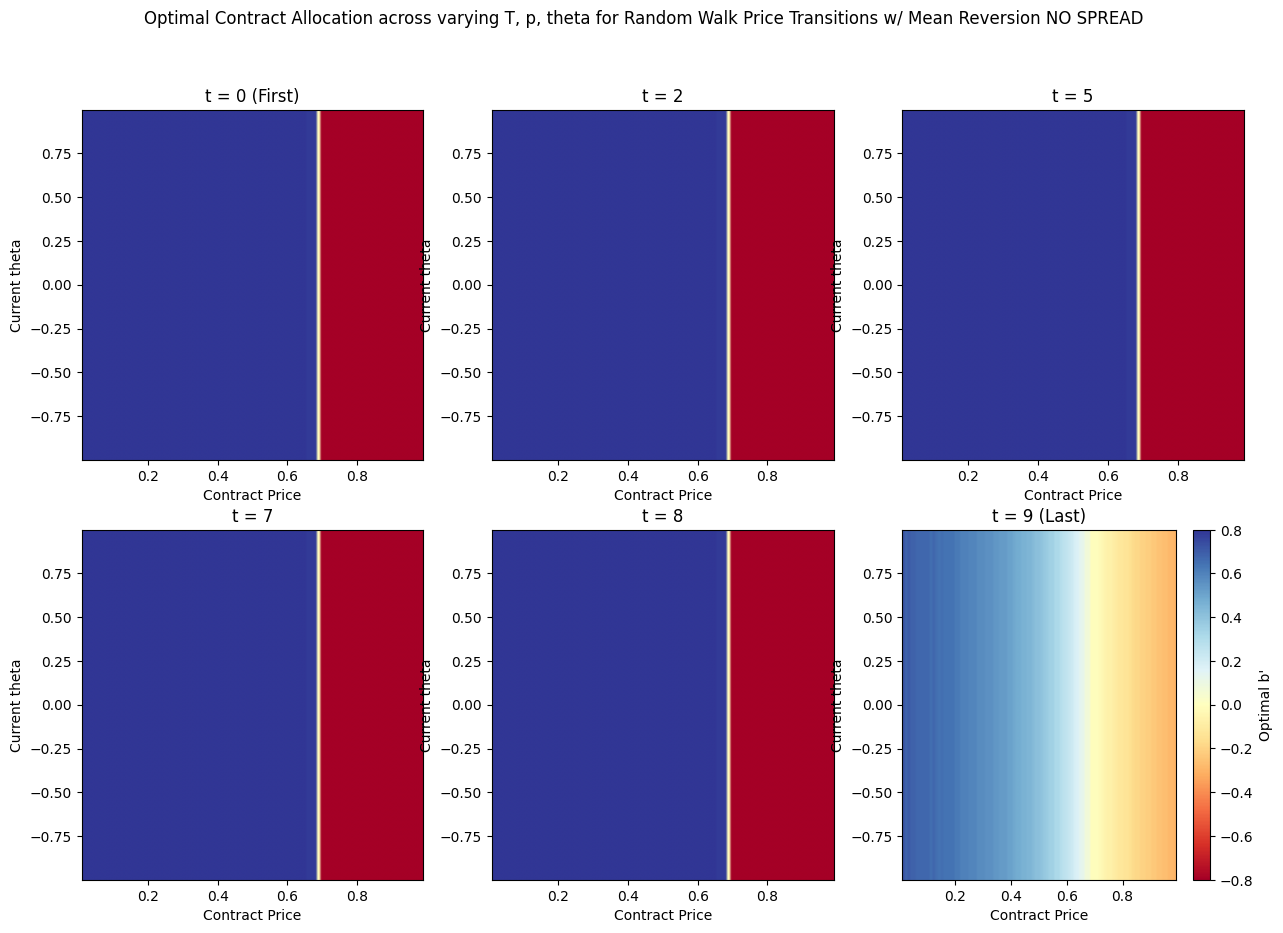

In [564]:
# Sample Policy 3: Random Walk Price Transitions w/ Mean Reversion

T = 10
n_prices = 99
psub = .7

V, policy = run_dp(make_transition_matrix(fair_value=psub,volatility=.2,mean_reversion=0.5,n_prices=n_prices),
                             p_subj=psub,
                             T = T,
                             gamma_yes_b = 0,
                             gamma_yes_s = 0,
                             gamma_no_b = 0,
                             gamma_no_s = 0,
                             n_theta = 3000,
                             n_b_tick = 100,
                             n_prices = n_prices)

# Create heatmaps for key time points
key_times = [0, T//4, T//2, 3*T//4, T-2, T-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, t in enumerate(key_times):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(policy[t], 
                   aspect='auto',
                   origin='lower',
                   extent=[C_MIN, C_MAX, THETA_MIN, THETA_MAX],  # Price: 0.01-0.99, Theta: -0.99-0.99
                   vmin=B_TICK_MIN, vmax=B_TICK_MAX,
                   cmap='RdYlBu')
    
    ax.set_xlabel('Contract Price')
    ax.set_ylabel('Current theta')
    ax.set_title(f't = {t}' + (' (First)' if t == 0 else ' (Last)' if t == T-1 else ''))
    
    # Add colorbar only to last plot
    if idx == len(key_times) - 1:
        fig.colorbar(im, ax=ax, label='Optimal b\'')

plt.suptitle("Optimal Contract Allocation across varying T, p, theta for Random Walk Price Transitions w/ Mean Reversion NO SPREAD")
plt.show()


Without spread, optimal allocation becomes independent of current allocation (since essentially we are allowed to sell all our contracts and buy them again at the same time step), so we see only vertical lines below.

This means that spreads don't just simply reduce trading activity, they represent a form of cost of making large jumps in positions, which makes our policy path dependent. 